# Explore bias towards entropy induced by activation function

After observing the activations in the hidden layers over the course of training, we want to get a better feeling for the effect that the activation function has on the mutual information of these layers with the input. As the feed-forward mapping of the network is deterministic (up to numerical precision), the mutual information of the hidden layer with the input boils down to the entropy of the hidden layer. 

In the following we will create an artificial sample of data and manipulate it by applying different activation functions. We will compare the entropy of the output with the entropy of the original distribution. Furthermore, we will quantify the effect that different activation functions have on the entropy of the representation, which we call the inherent bias towards the entropy for that activation function.



In [1]:
import numpy as np
np.random.seed(0)
from scipy import stats
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.contrib.eager as tfe
tfe.enable_eager_execution()

We uniformly draw 4096 samples from the interval $[-3, 3]$. Below we see the distribution of these values in a histogram with 50 bins. In this simulation the histogram counts serve as the "activation pattern" that could appear in a hidden layer of a neural network for uniformly distributed activations. Moreover we calculate the entropy of this hypothetical activation pattern.

The entropy *H* is calculated as $$\textit{H} = -\sum(\text{pk} \cdot \log(\text{pk}), \text{axis}=0), $$

with pk = sequence of probabilities for a given distribution.

Entropy of the uniform distribution: 5.635258672316384


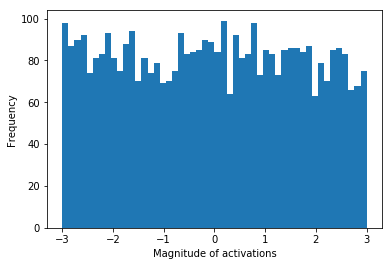

In [8]:
number_of_samples = 4096
uniform = np.random.uniform(-3, 3, (number_of_samples,)).astype(np.float32)
uniform_hist, _, _ = plt.hist(uniform, bins=50)
entropy_uniform_dist = stats.entropy(uniform_hist, base=2)
print(f'Entropy of the uniform distribution: {entropy_uniform_dist}')
plt.xlabel("Magnitude of activations")
plt.ylabel("Frequency")
plt.show()

In [9]:
def hard_sigmoid(x):
    lower_bound = -2.5
    upper_bound = 2.5
    linear = 0.2 * x + 0.5
    linear[x < lower_bound] = 0
    linear[x > upper_bound] = 1
    return linear

def linear(x):
    return x

activation_functions = [tf.nn.sigmoid, tf.nn.tanh, tf.nn.relu, tf.nn.softsign, tf.nn.softplus, hard_sigmoid,
                       tf.nn.selu, tf.nn.relu6, tf.nn.elu, tf.nn.leaky_relu, linear]
print(uniform.dtype)

float32


Apply activation functions to the inputs

In [10]:
outputs = {}
for actvation_function in activation_functions:
    try:
        outputs[actvation_function.__name__] = actvation_function(uniform).numpy().astype(np.float32)
    except AttributeError:
        outputs[actvation_function.__name__] = actvation_function(uniform)

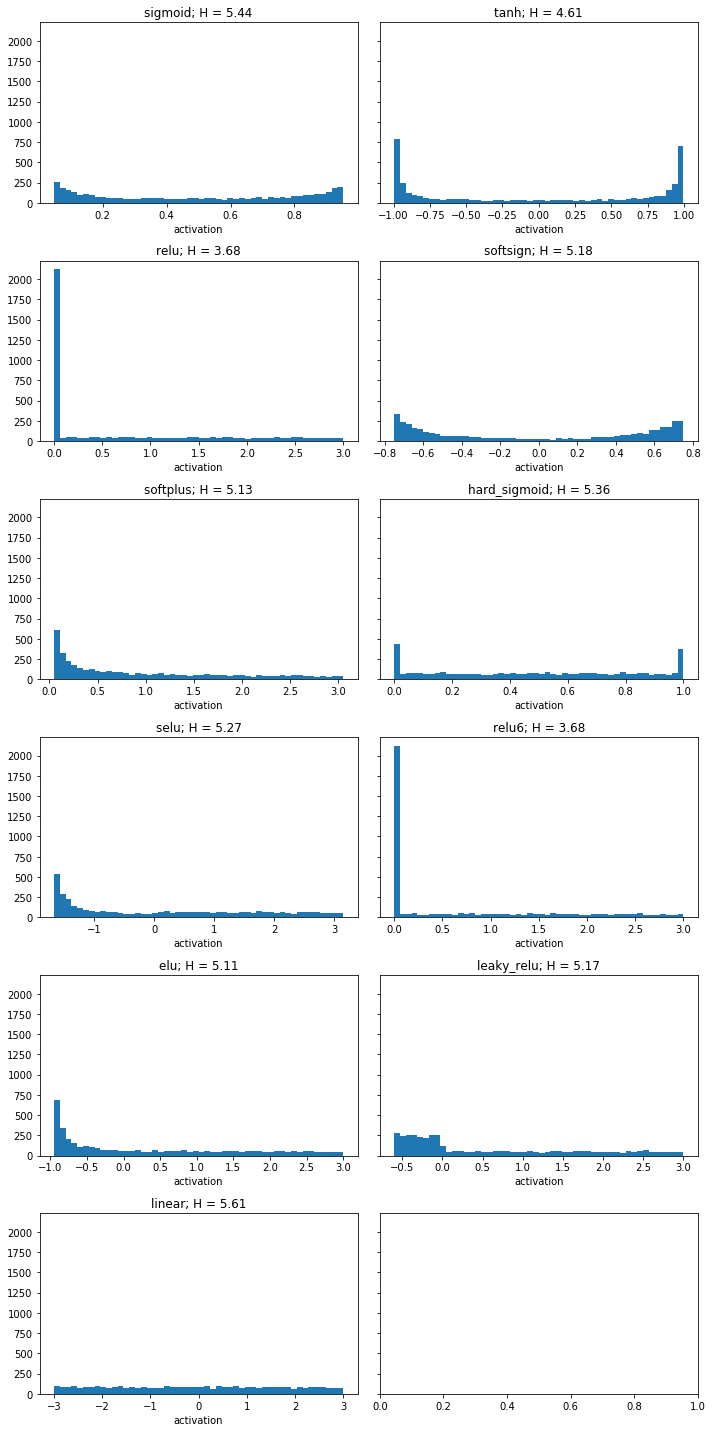

In [11]:
fig, ax = plt.subplots(nrows=6, ncols=2, figsize=(10, 20), sharey=True)
ax = ax.flat
entropies = {}
for ax_idx, (activation_function, Y) in enumerate(outputs.items()):
    min_acitivity = Y.min()
    max_acitivity = Y.max()
   
    bins = np.linspace(min_acitivity, max_acitivity, 50)
    digitized, _ = np.histogram(Y, bins=bins)

    entropies[activation_function] = stats.entropy(digitized, base=2)
    
    ax[ax_idx].hist(Y,  bins=50)
    ax[ax_idx].set(title=f'{activation_function}; H = {entropies[activation_function]:.2f}', xlabel='activation')
plt.tight_layout()
plt.show()

In [12]:
print(entropies)

{'sigmoid': 5.436941771484909, 'tanh': 4.611761859823233, 'relu': 3.678784202299869, 'softsign': 5.178051869282188, 'softplus': 5.130550321643636, 'hard_sigmoid': 5.355571003469254, 'selu': 5.268086596952946, 'relu6': 3.678784202299869, 'elu': 5.111927512758456, 'leaky_relu': 5.172949730778948, 'linear': 5.606609983330086}


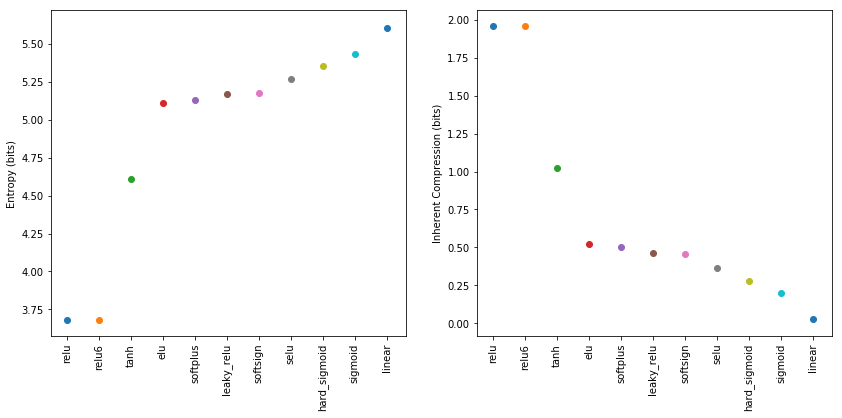

In [13]:
sorted_entropies = sorted(entropies.items(), key=lambda kv: kv[1])
xlabels = list(zip(*sorted_entropies))[0]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
for index, (activation_function, H) in enumerate(sorted_entropies):
    ax[0].scatter(index, H)
    ax[1].scatter(index, entropy_uniform_dist-H)

ax[0].set_xticks(range(len(entropies.keys())))
ax[0].set_xticklabels(xlabels, rotation=90)
ax[0].set_ylabel('Entropy (bits)')

ax[1].set_xticks(range(len(entropies.keys())))
ax[1].set_xticklabels(xlabels, rotation=90)
ax[1].set_ylabel('Inherent Compression (bits)')

plt.show()

In [14]:
# take a percentage of previously sampled points
relu_like_dist =_set_percentage_to_zero(uniform, 50)

relu_like_hist, _, _ = plt.hist(relu_like_dist, bins=30)
entropy_relu_like_dist = stats.entropy(relu_like_hist, base=2)
print(f'Entropy of the relu like distribution: {entropy_relu_like_dist}')
print(f'Compared to the uniform distribution, this is a decrease of entropy by {entropy_uniform_dist-entropy_relu_like_dist} bits.')
plt.xlabel("Magnitude of activations")
plt.ylabel("Frequency")
plt.show()

NameError: name '_set_percentage_to_zero' is not defined

We can conclude from this simple experiment, that the `relu` nonlinearity has a strong bias on the mutual information of the representation with the input, as it imposes a lot of structure onto the activations. We hypothesize that `relu` activated hidden layers should therefore carry less information about the input as compared to a `tanh` activated layers. This effect should be immediate from the very beginning of the training. Moreover, within the terminology of the information bottleneck, this boils down to "immediate compression". The exact magnitude of this effect within the experiments we ran has still to be estimated. 

In order to visualize the effect of setting portions of the data samples to zero, we plot the the resulting entropy against the proportion of samples which are set to zero.

In [18]:
entropies = []
for percentage in np.arange(0, 100, 1):
    relu_like = _set_percentage_to_zero(uniform, percentage)
    relu_like_hist, _ = np.histogram(relu_like, bins=30)
    entropy_relu_like_dist = stats.entropy(relu_like_hist, base=2)
    entropies.append(entropy_relu_like_dist)

plt.figure()
plt.plot(entropies)
plt.xlabel("Percentage of activations set to 0")
plt.ylabel("Entropy of the activation histogram")
plt.show()

NameError: name '_set_percentage_to_zero' is not defined

In [19]:
def _copy_neighbour(to_transform, iterations):
    """Sets every second value of a vector to the value of the preceding entry"""
    to_transform = np.copy(to_transform)
    to_transform_mass = np.sum(to_transform)

    #shuffle nad replace all nonzero values to simulate more compact representation
    nonzeros = to_transform[to_transform != 0]
    zeros = np.zeros((to_transform.shape[0] - nonzeros.shape[0]))

    for iteration in range(iterations):
        nonzeros[1::2] = nonzeros[0:-1:2]
        np.random.shuffle(nonzeros)

    transformed = np.concatenate((nonzeros, zeros))
    return transformed

By repeatedly setting the value of every second data sample to its preceding neighbour, we "simplify" the representation in the information theoretic sense. After 200 iterations of this transformation, we arrive at a distributions which looks qualitatively similar to those observed after restricting the norm of the weight vector. (See notebook 7.weight_renormalization.ipynb for experiment details)

In [20]:
# now impose structure on the 1st till 30th bin
transformed = _copy_neighbour(relu_like_dist, 200) 

transformed_hist, _, _ = plt.hist(transformed, bins=30)
entropy_transformed_dist = stats.entropy(transformed_hist, base=2)
print(f'Entropy of the transformed distribution: {entropy_transformed_dist}')
print(f'Compared to the relu like distribution this is a decrease of {entropy_relu_like_dist-entropy_transformed_dist} bits')
plt.xlabel("Magnitude of activations")
plt.ylabel("Frequency")
plt.show()

NameError: name 'relu_like_dist' is not defined

We observe that the effect of imposing structure on the non-zero activations reduced the entropy further, but not even matching the amount of redution that was obtained by the relu activation alone. 

We therefore conclude that the bias of the relu activation function towards the mutual information with the input is strong, especially as the its size is not even matched by artifically imposed structure (for example by restricted weight norm) on the nonzero activations. We furthermore hypothesize that the relu compresses in the sense of the information botteneck framework, but does this immediately and not in a distinct phase of the training process. A more qunatitative approach testing this hypothesis is subject of another notebook. 

In [ ]:
entropies = []
for iterations in np.arange(0, 200, 1):
    dist = _copy_neighbour(relu_like_dist, iterations)
    hist, _ = np.histogram(dist, bins=30)
    entropy_dist = stats.entropy(hist, base=2)
    entropies.append(entropy_dist)

plt.figure()
plt.plot(entropies)
plt.xlabel("Number of copy_neighbour iterations")
plt.ylabel("Entropy of the activation histogram")
plt.show()

The plot above shows the an example of development of entropy over the iterations of "simplifying" the representation. Interesting in this regard is the high variability. The decreasing trand for the value of the entroy with increasing number of iterations is clearly visible.